### Problem statement/ proposed solution metrics

In this notebook, we will attempt to address the problem task at hand defined by PASSNYC:
* There is a vast ethnic disparity in the percentage of registering for/ clearing SHSAT and hence resulting lack of diversity in the specialized high schools which offer admissions based on the results of SHSAT.
* Analyse the cause for the low percentage of black/ hispanic students clearing the test and suggest solutions which can help bring more diversity into these specialized high schools. These would include <br>
 a) Identifying schools with students eligible for SHSAT <br>
 b) Identifying possible reasons for undderperformance/ non appearance in SHSAT <br>
 c) Pinpointing the key improvements needed in those schools <br>
 d) Explaining the rational/ statistics behind those decisions <br>

### Notable facts
Some facts about SHSAT which will be explain the relevance of the problem and wouldl be helpful in understanding the observations posted below:
* Specialized High Schools Admissions Test is the admissions criterion for eight of the nine specialized high schools
* Students of class 8 and 9 are eligible to appear in the test
* There are two SHSAT sections: English Language Arts (ELA) and Math
* The three highest-status schools—Stuyvesant, Bronx Science, and Brooklyn Tech—have black and Latino student populations of 4, 9, and 13 percent, respectively, far below the 70 percent in public schools citywide.
* The only way to register for the SHSAT is through your middle school guidance counselor. 

### References
[This article](https://www.theatlantic.com/education/archive/2018/06/new-york-high-schools-stuyvesant-brooklyn-bronx/562772/) is a very good read for people who wish to understand the problem in more detail and how it came into being


<img src='../../../images/kaggle_homepage.png'>

### About the dataset
2 files available
1. <b> 2016 School Explorer.csv </b> : 1272 rows, each describing a separate school in terms of its 161 features which include
    * Locality information (Lat/ Long/ ZIP/ Address/ City (45 unique cities) / District (32)/ SED code (unique to school) )
    * Students of each ethnicity registered in ELA/ Maths in different grades
    * School evaluation metrics
    * ELL(English Language Learners) information
            
2. <b> D5 SHSAT Registrations and Testers.csv </b> : Contains information on the students of 30 schools of district 5 who registered for/ actually appeared for SHSAT, along with the breakdown by ethnicity.
 

### First things first. 

Our primary focus in this notebook 
* Reasons for poor performace in SHSAT 
* Eligibility criterion : Grade 8/9 students
* Dataset : 
    *  Total 1272 schools 
    *  619 schools have classes beyond grade 5. Hence, we have focused on schools which have students eligible for SHSAT. 
* We understand that the other schools are also relevant as they provide the primary education on which the next ones build but we will come to those later on in the notebook. (Coming Soon)

Our analysis includes the follwing points:
1. City wise School distribution
1. Attacking the absent ratio
1. School performance Indicator
1. Economic Need Index
1. Filtering out schools where most of the students are black / hispanic and their 4s scores are low
1. Crime
1. Teacher to student ratio
1. ENI / SPI based clustering
1. SHSAT Data Analysis

## City wise School distribution

<img src='../../../images/nyc_boroughs.png'>

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
import folium
import sklearn
import seaborn as sns

In [2]:
def percent_to_int(df_in):
    for col in df_in.columns.values:
        if col.startswith("Percent") or col.endswith("%") or col.endswith("Rate"):
            df_in[col] = df_in[col].astype(np.object).str.replace('%', '').astype(float)
    return df_in

In [3]:
df_schools_raw = pd.read_csv('../../../input/2016 School Explorer.csv')
df_schools_raw = df_schools_raw[df_schools_raw['Grade High'] != '0K']
df_schools_raw = percent_to_int(df_schools_raw)
df_schools_raw['School Income Estimate'] = df_schools_raw['School Income Estimate'].astype(np.object).str.replace('$', '').str.replace(',', '').str.replace('.', '').astype(float)

df_schools_relevant_grade = df_schools_raw[df_schools_raw['Grade High'].astype(int) > 5]

high_nan_columns = df_schools_raw.columns[df_schools_raw.isnull().mean()>0.95]
# print("Here are the fields having >95% NaNs which we can drop: \n")
# print(list(high_nan_columns))

df_schools = df_schools_relevant_grade.drop(high_nan_columns, axis=1)
print("We have %d relevant schools and %d fields describing the school/ students"%(df_schools.shape))

We have 626 relevant schools and 158 fields describing the school/ students


In [4]:
def plot_city_hist(df_schools, title_str):
    df_schools[['City']]

    # Read CSV file, get author names and counts.

    counter = Counter(df_schools['City'])
    city = counter.keys()
    city_count = counter.values()

    # Plot histogram using matplotlib bar().
    plt.figure(figsize=[8,6])
    indexes = np.arange(len(city))
    plt.bar(indexes, city_count)
    plt.xticks(indexes , city, rotation=90)
    plt.title(title_str)
    plt.show()

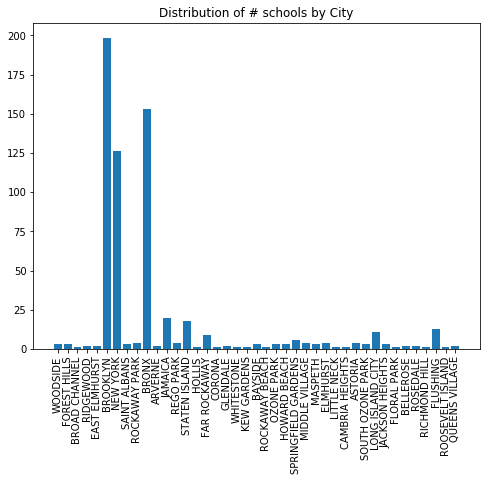

In [5]:
plot_city_hist(df_schools, 'Distribution of # schools by City')

## Attacking the absent ratio

The first and foremost aspect of the schools that we wish to address is the "chronically absent ratio" - if the number is too high for any given school - then the chances of improving that school, even by providing variety of resources would be very low. So, first we identify schools which have >40% of students being chronically absent.

[comment]: ![attendance_facts.png](attachment:attendance_facts.png)
<img src='../../../images/attendance_facts.png'>

Text(0.5,1,u'Histogram: Percent of Students Chronically Absent')

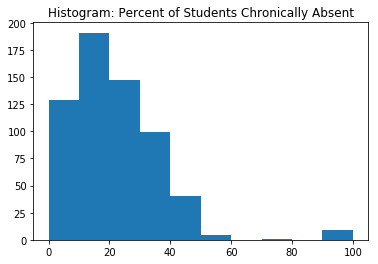

In [6]:
plt.figure(figsize = [6,4])
df_schools = df_schools.dropna(subset = ['Percent of Students Chronically Absent'])
plt.hist(df_schools['Percent of Students Chronically Absent'].values)
plt.title('Histogram: Percent of Students Chronically Absent')

In [7]:
chronically_absent_foi = ['School Name', 'Percent of Students Chronically Absent','Percent Black / Hispanic','Economic Need Index']

df_schools_ca = df_schools[df_schools['Percent of Students Chronically Absent'] > 40]
df_schools_nca = df_schools[df_schools['Percent of Students Chronically Absent'] < 40]

df_schools_ca[chronically_absent_foi].sort_values('Percent of Students Chronically Absent', ascending = False)

,School Name,Percent of Students Chronically Absent,Percent Black / Hispanic,Economic Need Index
1261,SUCCESS ACADEMY CHARTER SCHOOL - BRONX 2,100.0,98.0,0.794
1260,SUCCESS ACADEMY CHARTER SCHOOL - BRONX 1,100.0,96.0,0.825
1206,SUCCESS ACADEMY CHARTER SCHOOL - UPPER WEST,100.0,48.0,0.369
1203,SUCCESS ACADEMY CHARTER SCHOOL - HARLEM 5,100.0,95.0,0.789
1198,SUCCESS ACADEMY CHARTER SCHOOL - HARLEM 4,100.0,94.0,0.711
1197,SUCCESS ACADEMY CHARTER SCHOOL - HARLEM 3,100.0,94.0,0.720
1196,SUCCESS ACADEMY CHARTER SCHOOL - HARLEM 2,100.0,97.0,0.734
1173,BROOKLYN LAB CHARTER SCHOOL,100.0,89.0,0.639
1121,SUCCESS ACADEMY CHARTER SCHOOL - BED-STUY 1,100.0,96.0,0.750
300,NEW DIRECTIONS SECONDARY SCHOOL,74.0,98.0,0.920


In [8]:
print ('Economic Need Index of schools where percent of chronically absent students is high : %f'%df_schools_ca['Economic Need Index'].median())
print('%d schools have > 40%% students chronically absent'%(df_schools_ca.shape[0]))

Economic Need Index of schools where percent of chronically absent students is high : 0.835000
49 schools have > 40% students chronically absent


<b>Looking at the above statistics, we can say that, for the schools that have high percentage of chronically absent students:</b>
* Percentage of Black/Hispanic students is high
* Economic Need Index is high

## School performance Indicator

Next, we explore the 6 fields in the dataset which are indicative of the overall standing of the school. These features include:
* <b>Rigorous Instruction %</b> - Degree to which school curriculum and instructions engage students by fostering critical thinking.
* <b>Collaborative Teachers %</b> - Degree to which teachers participate in development, growth and contribution towards students and school.
* <b>Supportive Environment %</b> - Degree to which school establishes a culture where students feel safe and challenged to grow.
* <b>Effective School Leadership %</b> - Degree to which there is an instructional vision and the leadership is distributed for realising this vision.
* <b>Strong Family-Community Ties %</b> - Degree to which a school works in partnerships with families and other organizations to improve the school.
* <b>Trust %</b> - Degree of relationships of a school with students, teachers, families and adminstrators. 

[comment]:![SPI.jpg](attachment:SPI.jpg)

We show some typical values of these measures below:

In [9]:
features_list = ['Rigorous Instruction %',
'Collaborative Teachers %',
'Supportive Environment %',
'Effective School Leadership %',
'Strong Family-Community Ties %',
'Trust %']

df_schools[['School Name'] + features_list ].head()

,School Name,Rigorous Instruction %,Collaborative Teachers %,Supportive Environment %,Effective School Leadership %,Strong Family-Community Ties %,Trust %
3,P.S. 034 FRANKLIN D. ROOSEVELT,85.0,78.0,82.0,73.0,89.0,88.0
8,P.S. 140 NATHAN STRAUS,94.0,91.0,85.0,87.0,83.0,93.0
10,P.S. 184M SHUANG WEN,90.0,81.0,91.0,67.0,83.0,85.0
11,P.S. 188 THE ISLAND SCHOOL,100.0,100.0,99.0,99.0,92.0,99.0
12,ORCHARD COLLEGIATE ACADEMY,72.0,77.0,77.0,72.0,76.0,87.0


Text(0.5,0.98,u'School Performance features')

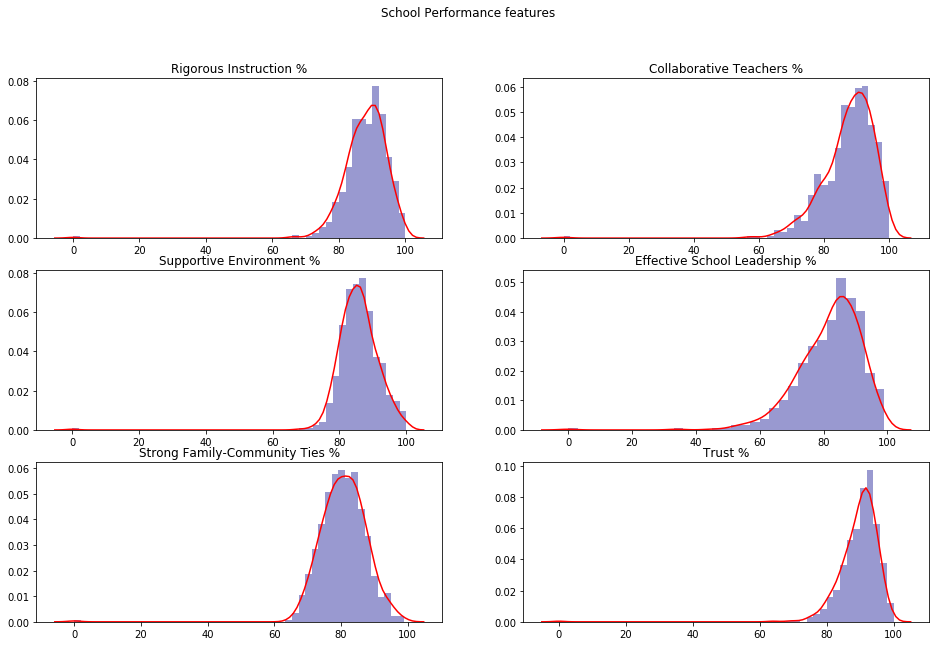

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 10))
for i in range(3):
    for j in range(2):
        ax[i, j].set_title(features_list[i*2 + j])
        sns.distplot(a=df_schools[features_list[i*2 + j]].dropna().values, kde_kws={"color": "red"}, color='darkblue', ax=ax[i, j])

fig.suptitle('School Performance features')
# fig.tight_layout()

#### Let's look at the correlation of these features.

In [11]:
df_schools[features_list].corr()

,Rigorous Instruction %,Collaborative Teachers %,Supportive Environment %,Effective School Leadership %,Strong Family-Community Ties %,Trust %
Rigorous Instruction %,1.000000,0.757568,0.720514,0.643093,0.540730,0.708931
Collaborative Teachers %,0.757568,1.000000,0.594114,0.915435,0.485351,0.882959
Supportive Environment %,0.720514,0.594114,1.000000,0.488354,0.581007,0.714141
Effective School Leadership %,0.643093,0.915435,0.488354,1.000000,0.444356,0.853213
Strong Family-Community Ties %,0.540730,0.485351,0.581007,0.444356,1.000000,0.588877
Trust %,0.708931,0.882959,0.714141,0.853213,0.588877,1.000000


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]), <a list of 6 Text xticklabel objects>)

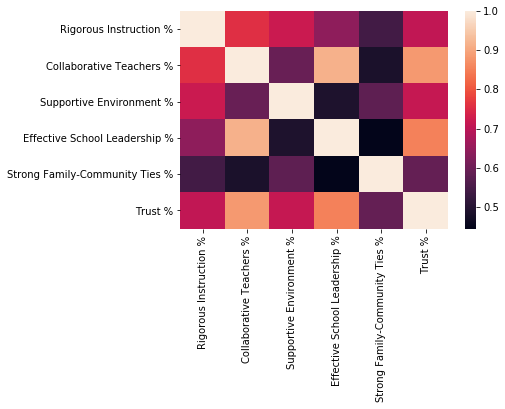

In [12]:
corr = df_schools[features_list].corr()
sns.heatmap(corr)
plt.xticks(rotation=90) 

<b>Analysis of correlation between features</b>
<br>Observing the correlation between different factors for rating a school, a high correlation was found between three of the features. A 'Principal Component Anaysis (PCA)' has been applied to get a single combined feature using all those three features.

In [13]:
correlated_features_list = ["Effective School Leadership %","Collaborative Teachers %","Trust %"]
corr_features_values = df_schools[correlated_features_list].values

from sklearn.decomposition import PCA

pca = PCA(n_components=1)
combined_feature_value = pca.fit_transform(corr_features_values)
df_schools['PCA Combined Feature'] = combined_feature_value
df_schools[correlated_features_list + ['PCA Combined Feature']].corr()

,Effective School Leadership %,Collaborative Teachers %,Trust %,PCA Combined Feature
Effective School Leadership %,1.000000,0.915435,0.853213,-0.979714
Collaborative Teachers %,0.915435,1.000000,0.882959,-0.970069
Trust %,0.853213,0.882959,1.000000,-0.920314
PCA Combined Feature,-0.979714,-0.970069,-0.920314,1.000000


In [14]:
scaler = sklearn.preprocessing.MinMaxScaler()
scale_factor = 2*(df_schools['PCA Combined Feature'].corr(df_schools["Effective School Leadership %"])>0) -1 
df_schools['PCA Combined Feature'] =  scaler.fit_transform(scale_factor * df_schools['PCA Combined Feature'].values.reshape(-1,1))*100

In [15]:
df_schools[correlated_features_list + ['PCA Combined Feature']].corr()

,Effective School Leadership %,Collaborative Teachers %,Trust %,PCA Combined Feature
Effective School Leadership %,1.000000,0.915435,0.853213,0.979714
Collaborative Teachers %,0.915435,1.000000,0.882959,0.970069
Trust %,0.853213,0.882959,1.000000,0.920314
PCA Combined Feature,0.979714,0.970069,0.920314,1.000000


#### Weights to each factor for calculating School Performace Indicator:

* 1.0 := Supportive Environment % <br>
* 0.8 := Rigorous Instruction % <br>
* 0.7 := PCA combined feature % <br>
* 0.5 := Strong Family-Community Ties % <br>

NOTE: PCA combined features incorporates these three features - Effective School Leadership %, Collaborative Teachers %, Trust %

In [16]:
features = ['Rigorous Instruction %','Supportive Environment %','PCA Combined Feature',
            'Strong Family-Community Ties %']
weights = [0.8, 1, 0.7, 0.5]

df_schools['SPI'] = df_schools[features].dot(weights)

df_schools[features+['SPI']].head(5)

,Rigorous Instruction %,Supportive Environment %,PCA Combined Feature,Strong Family-Community Ties %,SPI
3,85.0,82.0,78.859046,89.0,249.701332
8,94.0,85.0,90.408101,83.0,264.985671
10,90.0,91.0,76.608591,83.0,258.126014
11,100.0,99.0,100.000000,92.0,295.000000
12,72.0,77.0,77.852373,76.0,227.096661


In [17]:
df_low_spi_schools = df_schools[df_schools['SPI'] < df_schools['SPI'].quantile(.25)]
df_high_spi_schools = df_schools[df_schools['SPI'] > df_schools['SPI'].quantile(.25)]

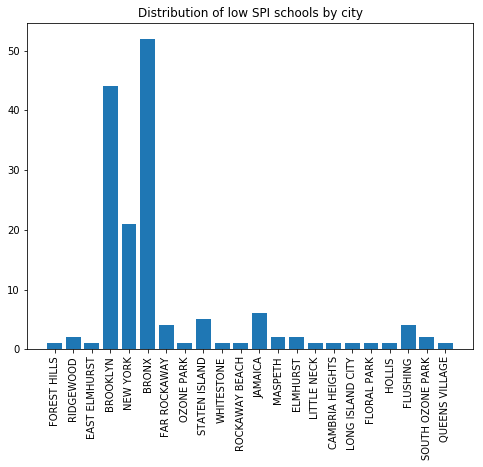

In [18]:
plot_city_hist(df_low_spi_schools, 'Distribution of low SPI schools by city')

In [19]:
df_low_spi_schools[['Average ELA Proficiency','Average Math Proficiency']].mean()

Average ELA Proficiency     2.366839
Average Math Proficiency    2.370323
dtype: float64

In [20]:
df_high_spi_schools[['Average ELA Proficiency','Average Math Proficiency']].mean()

Average ELA Proficiency     2.592795
Average Math Proficiency    2.703537
dtype: float64

## Economic Need Index

This metric reflects the socio-economics of the school population. 

<b>ENI</b> = (% temp housing) + (% HRA eligible x 0.5) + (% free lunch eligible x 0.5).

The higher this index, the higher is the economic need of the students

(array([  5.,  13.,  30.,  31.,  41.,  54.,  61., 135., 146., 104.]),
 array([0.059 , 0.1469, 0.2348, 0.3227, 0.4106, 0.4985, 0.5864, 0.6743,
        0.7622, 0.8501, 0.938 ]),
 <a list of 10 Patch objects>)

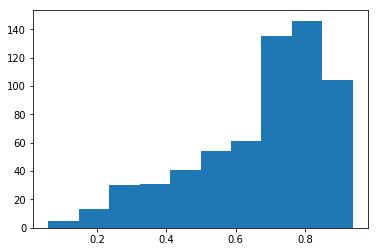

In [21]:
plt.hist(df_schools[['Economic Need Index']].values)

Below is the visualization of School Income Estimate and Economic Need Index of schools. In the plot, each circle corresponds to a school. The color represents ENI of the school and size of the circle represents school income.

Text(0.5,0,u'Longitude')

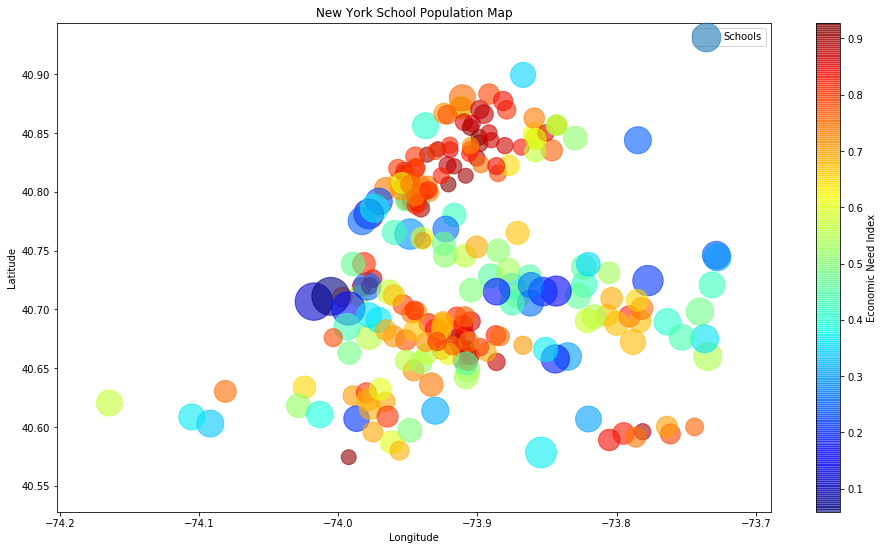

In [22]:
fig, ax = plt.subplots(figsize=(16,9))
ax = df_schools.plot(kind="scatter", x="Longitude", y="Latitude", 
                   s=df_schools['School Income Estimate']/10000, c="Economic Need Index", cmap=plt.get_cmap("jet"), 
                   label='Schools', title='New York School Population Map', 
                   colorbar=True, alpha=0.6, ax=ax)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

Below is the visualization of School Income Estimate and percent of black students in the schools. In the plot, each circle corresponds to a school. The color represents Percent Black students of the school and size of the circle represents Economic Need Index.

Text(0.5,0,u'Longitude')

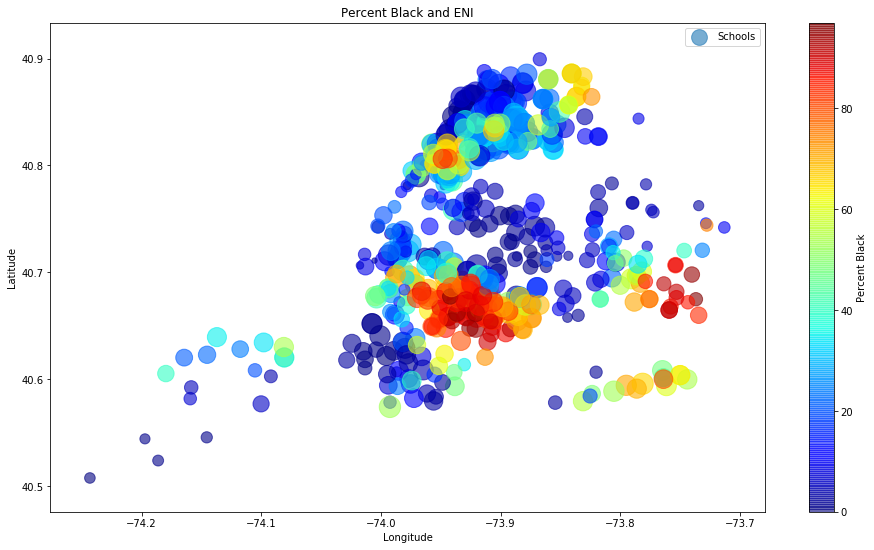

In [23]:
fig, ax = plt.subplots(figsize=(16,9))
ax = df_schools.plot(kind="scatter", x="Longitude", y="Latitude", 
                   s=df_schools['Economic Need Index']*500, c="Percent Black", cmap=plt.get_cmap("jet"), 
                   label='Schools', title='Percent Black and ENI', 
                   colorbar=True, alpha=0.6, ax=ax)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

In [24]:
lower_bound = df_schools['Economic Need Index'].quantile(0.75)
df_schools_high_eni = df_schools[df_schools['Economic Need Index'] > lower_bound]
df_schools_low_eni = df_schools[df_schools['Economic Need Index'] < 0.25]

In [25]:
df_schools_high_eni[['School Name', 'Economic Need Index', 'Percent Black / Hispanic']].sort_values('Economic Need Index', ascending = False)

,School Name,Economic Need Index,Percent Black / Hispanic
298,NEW MILLENNIUM BUSINESS ACADEMY MIDDLE SCHOOL,0.938,98.0
283,I.S. 219 NEW VENTURE SCHOOL,0.929,98.0
1247,MOTT HAVEN ACADEMY CHARTER SCHOOL,0.928,98.0
762,BROWNSVILLE COLLABORATIVE MIDDLE SCHOOL,0.925,96.0
300,NEW DIRECTIONS SECONDARY SCHOOL,0.920,98.0
346,"P.S. 279 CAPTAIN MANUEL RIVERA, JR.",0.918,96.0
11,P.S. 188 THE ISLAND SCHOOL,0.917,93.0
299,I.S. 339,0.913,98.0
714,P.S. 288 THE SHIRLEY TANYHILL,0.912,90.0
363,M.S. 390,0.911,98.0


In [26]:
df_schools_high_eni[['Average ELA Proficiency','Average Math Proficiency']].mean()

Average ELA Proficiency     2.247792
Average Math Proficiency    2.261688
dtype: float64

In [27]:
df_schools_low_eni[['Average ELA Proficiency','Average Math Proficiency']].mean()

Average ELA Proficiency     3.267917
Average Math Proficiency    3.422083
dtype: float64

We have divided the schools into two segments based on the Economic Need Index. And after this division, the performace of the students in Math and ELA was compared.<br>
As expected, the students of schools with higher ENI have performed poorly in both the subject by a significant margin.

#### Filtering out schools where most of the students are black / hispanic and their 4s scores are low

This analysis targets the schools where number of Black / Hispanic students are more and the percent of Black/ Hispanic students scoring 4 in Math and ELA is less.

In [28]:
def find_schools_with_black_high_4s_low(df, grade = 5, black_per_threshold = 90, all_students_threshold = 5):
    math_black_students = "Grade {} Math 4s - Black or African American".format(grade)
    math_hispanic_students = "Grade {} Math 4s - Hispanic or Latino".format(grade)
    math_all_students = "Grade {} Math 4s - All Students".format(grade)
    
    df_schools = df.copy()
    
    df_schools['4s ratio black / hispanic'] = (df_schools[math_black_students] + df_schools[math_hispanic_students])/ df_schools[math_all_students]
    df_schools_black_4s = df_schools[np.logical_and(df_schools['Percent Black / Hispanic'] > black_per_threshold, df_schools[math_all_students] > all_students_threshold)]
    df_schools_black_4s.dropna(inplace=True)
    
    df_schools_black_4s_low = df_schools_black_4s[df_schools_black_4s['4s ratio black / hispanic'] < 0.5]
    num_schools = len(df_schools_black_4s_low)                      
    
    return df_schools_black_4s_low

In [29]:
schools_with_black_high_4s_low = []

In [30]:
for grade in xrange(5,9):
    df_schools_with_black_high_4s_low = find_schools_with_black_high_4s_low(df_schools, grade=grade)
    schools_with_black_high_4s_low.extend(np.unique(df_schools_with_black_high_4s_low['School Name']))

schools_with_black_high_4s_low = list(set(schools_with_black_high_4s_low))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [31]:
schools_with_black_high_4s_low

['P.S. 108 ASSEMBLYMAN ANGELO DEL TORO EDUCATIONAL COMPLEX',
 'ICAHN CHARTER SCHOOL',
 'ICAHN CHARTER SCHOOL 4',
 'HARLEM VILLAGE ACADEMY LEADERSHIP CHARTER SCHOOL',
 'WASHINGTON HEIGHTS ACADEMY',
 'HARLEM PREP CHARTER SCHOOL',
 'P.S. 129 JOHN H. FINLEY',
 'BUSHWICK ASCEND CHARTER SCHOOL',
 'P.S. 235 JANICE MARIE KNIGHT SCHOOL',
 'BRONX ACADEMY OF PROMISE CHARTER SCHOOL',
 'THE GORDON PARKS SCHOOL',
 'SUCCESS ACADEMY CHARTER SCHOOL - BRONX 2',
 'ACHIEVEMENT FIRST EAST NEW YORK CHARTER SCHOOL',
 'ACHIEVEMENT FIRST CROWN HEIGHTS CHARTER SCHOOL',
 'BRONX CHARTER SCHOOL FOR THE ARTS']

In [32]:
df_filtered_schools = df_schools[df_schools['School Name'].isin(schools_with_black_high_4s_low)]
df_filtered_schools[['School Name', 'City', 'Economic Need Index', 'SPI']]

,School Name,City,Economic Need Index,SPI
116,P.S. 108 ASSEMBLYMAN ANGELO DEL TORO EDUCATION...,NEW YORK,0.843,250.659931
137,P.S. 129 JOHN H. FINLEY,NEW YORK,0.854,253.848145
189,WASHINGTON HEIGHTS ACADEMY,NEW YORK,0.777,273.752232
601,P.S. 235 JANICE MARIE KNIGHT SCHOOL,BROOKLYN,0.520,265.985192
990,THE GORDON PARKS SCHOOL,ROSEDALE,0.358,255.315343
1116,ACHIEVEMENT FIRST CROWN HEIGHTS CHARTER SCHOOL,BROOKLYN,0.570,247.994694
1118,ACHIEVEMENT FIRST EAST NEW YORK CHARTER SCHOOL,BROOKLYN,0.693,265.012899
1171,BUSHWICK ASCEND CHARTER SCHOOL,BROOKLYN,0.760,243.979200
1189,HARLEM VILLAGE ACADEMY LEADERSHIP CHARTER SCHOOL,NEW YORK,0.722,249.109716
1210,HARLEM PREP CHARTER SCHOOL,NEW YORK,0.815,258.132590


In [33]:
school_map = folium.Map([df_filtered_schools['Latitude'].mean(), df_filtered_schools['Longitude'].mean()], 
                        zoom_start=11,
                        tiles='Stamen Terrain')

for index in df_filtered_schools.index:
    row = df_filtered_schools.loc[index]
    school_name = str(row['School Name'])
    
    color = 'blue'
    folium.Marker([row['Latitude'], row['Longitude']], popup=school_name, icon=folium.Icon(color=color)).add_to(school_map)

school_map

As shown in the map, these are the schools which have high number of black students and a lower number of students who have scored 4 in Math and ELA. As seen from the map, most of such schools lie in Bronx.

## Analysis of Crimes from school safety report

Data description: The data we have used for this analysis has the number of different types of crimes school wise over 3 different years (2013-14, 2014-15, 2015-16) for approximately 2000 schools.<br>

The crimes are divided into 5 categories:
1. Major Crime
1. Violent Crime
2. Other Crime
3. Property Crime
4. Non-Criminal Crime
<br>

We have merged this data with the original dataset of schools and we have analysed the imapct of criminal activities around the schools on the performance of students.

<img src = ../../../images/trump_school_safety.jpg>
[comment]: ![trump_school_safety.jpg](attachment:trump_school_safety.jpg)

In [34]:
df_crime = pd.read_csv('../../../input/2010-2016-school-safety-report.csv')

intersection = set(df_crime['DBN']).intersection(set(df_schools['Location Code']))
print('%d schools found in the supplementary dataset out of %d in original dataset')%(len(intersection), len(df_schools))

crimes_col = ['Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N']
crimes = df_crime.groupby(['DBN'], as_index=False)[crimes_col].sum()

merged_safety_df = pd.merge(crimes[crimes_col + ['DBN']], df_schools, how='inner', left_on=['DBN'], right_on=['Location Code'])
merged_safety_df.dropna(subset=crimes_col, inplace=True,how='all')

541 schools found in the supplementary dataset out of 620 in original dataset


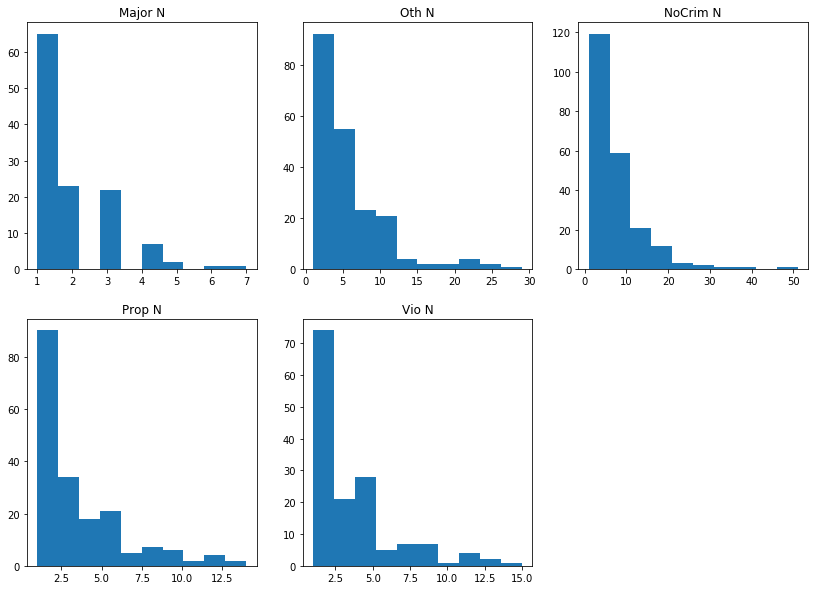

In [35]:
def plot_crime_histogram(column_name, i):
    plt.subplot(2,3,i+1)
    plt.hist(merged_safety_df[column_name][merged_safety_df[column_name]!=0])
    plt.title(column_name)
    
plt.figure(figsize = [14,10])    
for i,column_name in enumerate(crimes_col):
    plot_crime_histogram(column_name, i)

In [36]:
violent_df = merged_safety_df[merged_safety_df['Vio N'] > 4]
print len(violent_df)
major_crime_df = merged_safety_df[merged_safety_df['Major N'] > 2]
print len(major_crime_df)

43
33


In [37]:
corr = crimes[crimes_col].corr()
print corr

           Major N     Oth N  NoCrim N    Prop N     Vio N
Major N   1.000000  0.746759  0.682164  0.807288  0.772462
Oth N     0.746759  1.000000  0.869463  0.932849  0.890065
NoCrim N  0.682164  0.869463  1.000000  0.785599  0.800293
Prop N    0.807288  0.932849  0.785599  1.000000  0.744577
Vio N     0.772462  0.890065  0.800293  0.744577  1.000000


(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text xticklabel objects>)

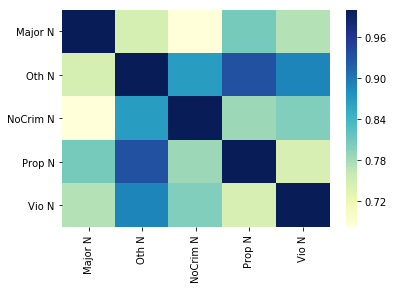

In [38]:
sns.heatmap(corr, cmap="YlGnBu")
plt.xticks(rotation=90) 

Looking at the correlation matrix of number of crimes of 5 differnt categories, it can be observed that they are highly correlated amongst each other. Hence, applying Principal Component Analysis (PCA) on these 5 features, we reduced it to 1 feature. This new feature is called "School Risk Index" which quantifies the safetly of a school. Lower the SRI, safer is the school.

In [39]:
features_pca = merged_safety_df[crimes_col].values

from sklearn.decomposition import PCA

school_crime_pca = PCA(n_components=1)
school_crime_pca.fit(features_pca)
reduced_crime_features = school_crime_pca.transform(features_pca)
print school_crime_pca.explained_variance_ratio_

[0.88755962]


In [40]:
import sklearn
scaler = sklearn.preprocessing.MinMaxScaler()
adjusted_reduced_crime_features = scaler.fit_transform(reduced_crime_features)

merged_safety_df['SRI'] = adjusted_reduced_crime_features

print('Correlation of risk measure with different features: ')
print('School Performance Index: '  + str(merged_safety_df['SRI'].corr(merged_safety_df['SPI'])))
print('Percent of Students Chronically Absent: '  + str(merged_safety_df['SRI'].corr(merged_safety_df['Percent of Students Chronically Absent'])))

Correlation of risk measure with different features: 
School Performance Index: -0.23227986548478766
Percent of Students Chronically Absent: 0.10948647954632304


As expected, the correlation of SRI with SPI is negative whereas with that of percentage of students remaining chronically absent is positive. One of the possible explanations to this can be, high SRI suggests there are more number of crimes in that school due to which students do not attend the school leading in high absence ratio. Similarly, as number of crimes increases the rating of the school in the aspect of "Supportive Environment" reduces which in turn reduces SPI.

In [41]:
risky_schools_df = merged_safety_df[merged_safety_df['SRI']>merged_safety_df['SRI'].quantile(0.9)]
risky_schools_df.shape[0]

54

In [42]:
risky_schools_df

,Major N,Oth N,NoCrim N,Prop N,Vio N,DBN,School Name,SED Code,Location Code,District,...,Grade 8 Math 4s - Black or African American,Grade 8 Math 4s - Hispanic or Latino,Grade 8 Math 4s - Asian or Pacific Islander,Grade 8 Math 4s - White,Grade 8 Math 4s - Multiracial,Grade 8 Math 4s - Limited English Proficient,Grade 8 Math 4s - Economically Disadvantaged,PCA Combined Feature,SPI,SRI
3,4.0,7.0,10.0,2.0,9.0,01M188,P.S. 188 THE ISLAND SCHOOL,310100010188,01M188,1,...,0,3,0,0,0,0,3,100.000000,295.000000,0.271190
9,0.0,8.0,9.0,6.0,2.0,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",310100011539,01M539,1,...,0,0,0,0,0,0,0,66.131111,236.591778,0.246537
11,2.0,12.0,5.0,6.0,8.0,02M104,J.H.S. 104 SIMON BARUCH,310200010104,02M104,2,...,0,2,17,4,0,0,17,88.217474,251.352232,0.266869
31,4.0,14.0,32.0,10.0,7.0,02M655,LIFE SCIENCES SECONDARY SCHOOL,310200011655,02M655,2,...,0,0,0,0,0,0,0,78.683200,236.578240,0.675066
67,4.0,10.0,6.0,9.0,4.0,05M046,P.S. 046 ARTHUR TAPPAN,310500010046,05M046,5,...,0,0,0,0,0,0,1,86.460650,258.322455,0.259408
68,2.0,5.0,16.0,2.0,4.0,05M123,P.S. 123 MAHALIA JACKSON,310500010123,05M123,5,...,0,0,0,0,0,0,0,71.729459,241.610621,0.303611
75,3.0,21.0,25.0,12.0,10.0,05M499,FREDERICK DOUGLASS ACADEMY,310500011499,05M499,5,...,2,0,0,0,0,0,3,81.683807,246.378665,0.675298
77,3.0,11.0,11.0,11.0,3.0,05M670,THURGOOD MARSHALL ACADEMY FOR LEARNING AND SOC...,310500011670,05M670,5,...,0,0,0,0,0,0,0,87.467322,240.427126,0.341575
98,0.0,4.0,15.0,0.0,4.0,07X005,P.S. 5 PORT MORRIS,320700010005,07X005,7,...,0,0,0,0,0,0,0,83.712316,252.598621,0.265504
116,5.0,15.0,14.0,9.0,9.0,08X269,BRONX STUDIO SCHOOL FOR WRITERS AND ARTISTS,320800011269,08X269,8,...,0,1,0,0,0,0,0,85.430927,241.101649,0.446610


## Student to Teacher Ratio (STR)

We have used a dataset with student-teacher ratio (STR) and merged it with the original data of schools to analyse the impact of student-teacher ratio on the performance of students and schools indeed.

<b>Student-Teacher Ratio (STR) = Number of Students per Teacher for a particular school.

In [43]:
field_name = "SCHOOLWIDE PUPIL-TEACHER RATIO"
df_school_detail = pd.read_csv('../../../input/2010-2011-class-size-school-level-detail.csv')
df_school_detail["CSD"] =  df_school_detail['CSD'].astype('str').astype(np.object_).str.zfill(2)
df_school_detail["DBN_manual"] = df_school_detail["CSD"] + df_school_detail["SCHOOL CODE"] 
df_school_detail.dropna(subset=[field_name], inplace=True)

In [44]:
merged_str_df = pd.merge(df_school_detail, df_schools, how='inner', left_on=['DBN_manual'], right_on=['Location Code'])

Text(0.5,1,u'Number of Students per Teacher')

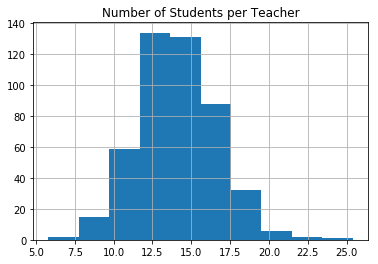

In [45]:
merged_str_df[field_name].hist()
plt.title("Number of Students per Teacher")

Looking at the histogram and deciding a threshold, we have divided the schools into two sections, one with high STR and other with low STR. Then after we analysed the average performance of students of these schools.

In [46]:
higher_ratio_str_df = merged_str_df[merged_str_df[field_name].astype(float)>18]
lower_ratio_str_df = merged_str_df[merged_str_df[field_name].astype(float)<12.5]

In [47]:
higher_ratio_str_df[['Average ELA Proficiency','Average Math Proficiency', 'Collaborative Teachers %', 'SPI','Percent Black / Hispanic','Economic Need Index']].mean()

Average ELA Proficiency       3.132308
Average Math Proficiency      3.277692
Collaborative Teachers %     89.115385
SPI                         259.299661
Percent Black / Hispanic     44.000000
Economic Need Index           0.436885
dtype: float64

In [48]:
lower_ratio_str_df[['Average ELA Proficiency','Average Math Proficiency', 'Collaborative Teachers %', 'SPI','Percent Black / Hispanic','Economic Need Index']].mean()

Average ELA Proficiency       2.310083
Average Math Proficiency      2.300826
Collaborative Teachers %     86.652893
SPI                         256.762657
Percent Black / Hispanic     87.595041
Economic Need Index           0.783099
dtype: float64

To our surprise, the schools with high STR are performing better as compared to the schools with low STR. The performance was observed by the average ELA proficiency and average Math proficiency. 

To inspect the abberant results, we tried looking how the collaboratively teachers work with students, percent of black/hispanic students and Economic Need Index of students. We observe that even though the number of students per teacher ratio is high, the teachers work more closely with the students and make them learn & understand the subject resulting into high performance in respective subjects. 

## ENI / SPI based clustering

As per our analysis, once we have the SPI which represents the performance of a school, the low performing schools should be targetted. We recommend that, PASSNYC could help the school students by setting up help centers. In order to serve maximum schools using least resources, we have clustered the poorly performing schools based on SPI and the schools having high ENI.

In [49]:
df_schools['SPI'].describe()

count    620.000000
mean     256.888725
std       17.704105
min        0.000000
25%      246.870357
50%      257.189439
75%      267.242915
max      295.000000
Name: SPI, dtype: float64

In [50]:
df_schools_clustering = df_schools.copy()
df_schools_clustering = df_schools_clustering.dropna(subset=['Longitude', 'Latitude'])
df_schools_clustering = df_schools_clustering[df_schools_clustering['SPI'] < df_schools_clustering['SPI'].quantile(0.25)]
df_schools_clustering = df_schools_clustering[df_schools_clustering['Economic Need Index'] > 0.8]

In [51]:
len(df_schools_clustering)

57

In [52]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=4)
model.fit(df_schools_clustering[['Longitude', 'Latitude']].values)
model.cluster_centers_
color = 'blue'

In [53]:
school_map = folium.Map([model.cluster_centers_[:, 1].mean(), model.cluster_centers_[:, 0].mean()], 
                        zoom_start=11,
                        tiles='Stamen Terrain') 
for row in model.cluster_centers_:
    folium.Marker([row[1], row[0]], icon=folium.Icon(color='red')).add_to(school_map)
for index in df_schools_clustering.index:
    row = df_schools_clustering.loc[index]
#     if row['Economic Need Index'] > 0.8 and row['SPI'] < 243.55:
    popup_text = "Economic Need Index : " + str(round(row['Economic Need Index'], 3)) + ' , SPI : ' + str(round(row['SPI'], 3))
    folium.Marker([row['Latitude'], row['Longitude']], popup=popup_text, icon=folium.Icon(color='blue')).add_to(school_map)

school_map

As observed from the map above, 4 help centers (depicted by red markers) could be set up to reach out to 57 schools with low SPI and high ENI.

## SHSAT Data Analysis

<b>Data Description:</b> This dataset provides information of 30 schools regarding number of students registering and appearing for SHSAT.

In [54]:
shsat_df = pd.read_csv('../../../input/D5 SHSAT Registrations and Testers.csv')
shsat_df.head()

,DBN,School name,Year of SHST,Grade level,Enrollment on 10/31,Number of students who registered for the SHSAT,Number of students who took the SHSAT
0,05M046,P.S. 046 Arthur Tappan,2013,8,91,31,14
1,05M046,P.S. 046 Arthur Tappan,2014,8,95,26,7
2,05M046,P.S. 046 Arthur Tappan,2015,8,73,21,10
3,05M046,P.S. 046 Arthur Tappan,2016,8,56,20,8
4,05M123,P.S. 123 Mahalia Jackson,2013,8,62,31,14


In [55]:
shsat_df['Took Percentage'] = shsat_df['Number of students who took the SHSAT'] / shsat_df['Number of students who registered for the SHSAT']

In [56]:
shsat_sorted_df = shsat_df.groupby(['DBN','School name'], as_index=False).sum()
shsat_sorted_df.head()

,DBN,School name,Year of SHST,Grade level,Enrollment on 10/31,Number of students who registered for the SHSAT,Number of students who took the SHSAT,Took Percentage
0,05M046,P.S. 046 Arthur Tappan,8058,32,315,98,39,1.597034
1,05M123,P.S. 123 Mahalia Jackson,8058,32,241,84,37,1.700780
2,05M129,P.S. 129 John H. Finley,8058,32,252,108,48,2.396452
3,05M148,Eagle Academy for Young Men of Harlem,6047,25,222,12,11,1.857143
4,05M157,The Urban Assembly School for Global Commerce,8058,36,309,7,3,1.333333


In [57]:
shsat_sorted_df = shsat_df.groupby(['DBN','School name'], as_index=False).sum()
shsat_sorted_df = shsat_sorted_df[['DBN','School name', 
                                 'Enrollment on 10/31', 
                                 'Number of students who registered for the SHSAT', 
                                 'Number of students who took the SHSAT']].join(shsat_df[['Year of SHST', 
                                                                                          'Grade level']], how='inner')
shsat_sorted_df = shsat_sorted_df.sort_values('Number of students who registered for the SHSAT',ascending=False)

In [58]:
shsat_sorted_df.head()

,DBN,School name,Enrollment on 10/31,Number of students who registered for the SHSAT,Number of students who took the SHSAT,Year of SHST,Grade level
22,84M336,KIPP Infinity Charter School,494,296,65,2016,8
29,84M726,KIPP STAR College Prep Charter School,292,292,96,2015,8
10,05M362,Columbia Secondary School,794,253,179,2015,8
20,84M065,Democracy Prep Endurance Charter School,567,194,94,2014,8
24,84M350,Democracy Prep Charter School,943,145,100,2014,8


In [59]:
shsat_sorted_df['Took Percentage'] = shsat_sorted_df['Number of students who took the SHSAT'] / shsat_sorted_df['Number of students who registered for the SHSAT']

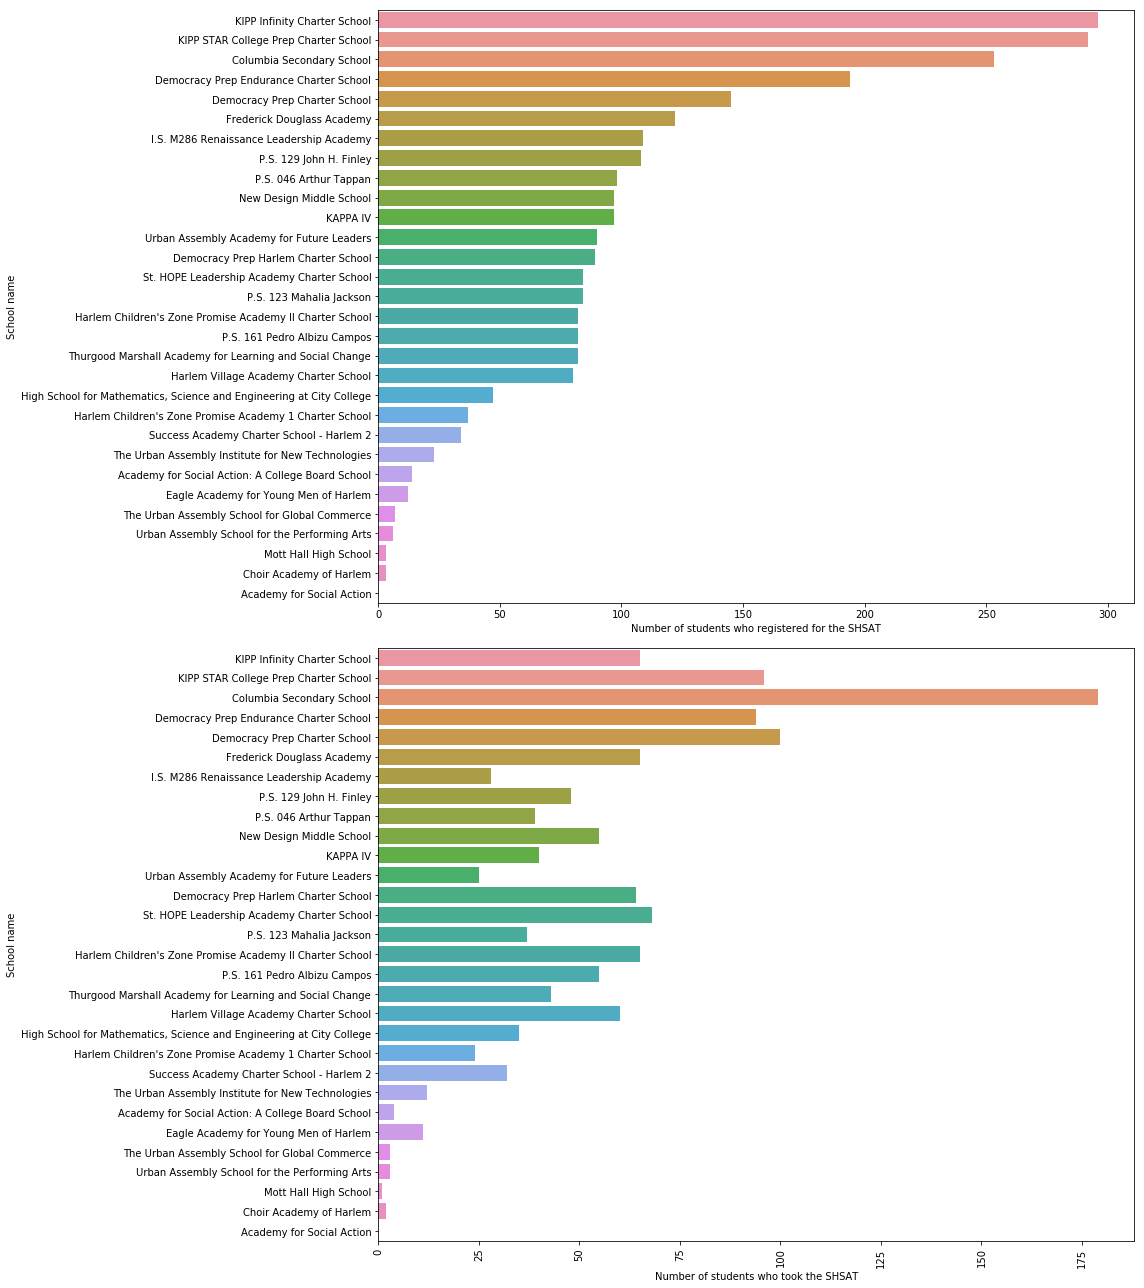

In [60]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 18))
sns.barplot(y='School name', x='Number of students who registered for the SHSAT', data=shsat_sorted_df, ax=ax[0], orient='h', ci=None)
sns.barplot(y='School name', x='Number of students who took the SHSAT', data=shsat_sorted_df, ax=ax[1], orient='h', ci=None)

plt.sca(fig.axes[-1])
plt.xticks(rotation=90)

fig.tight_layout()

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text xticklabel objects>)

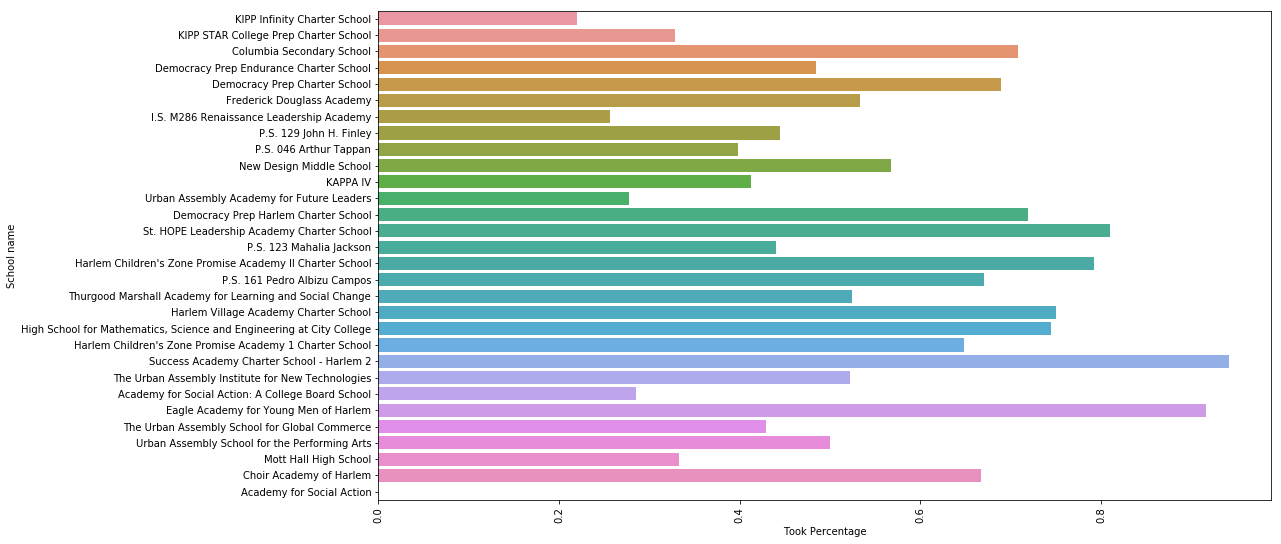

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
sns.barplot(y='School name', x='Took Percentage', data=shsat_sorted_df, ax=ax, orient='h', ci=None)
plt.xticks(rotation=90)

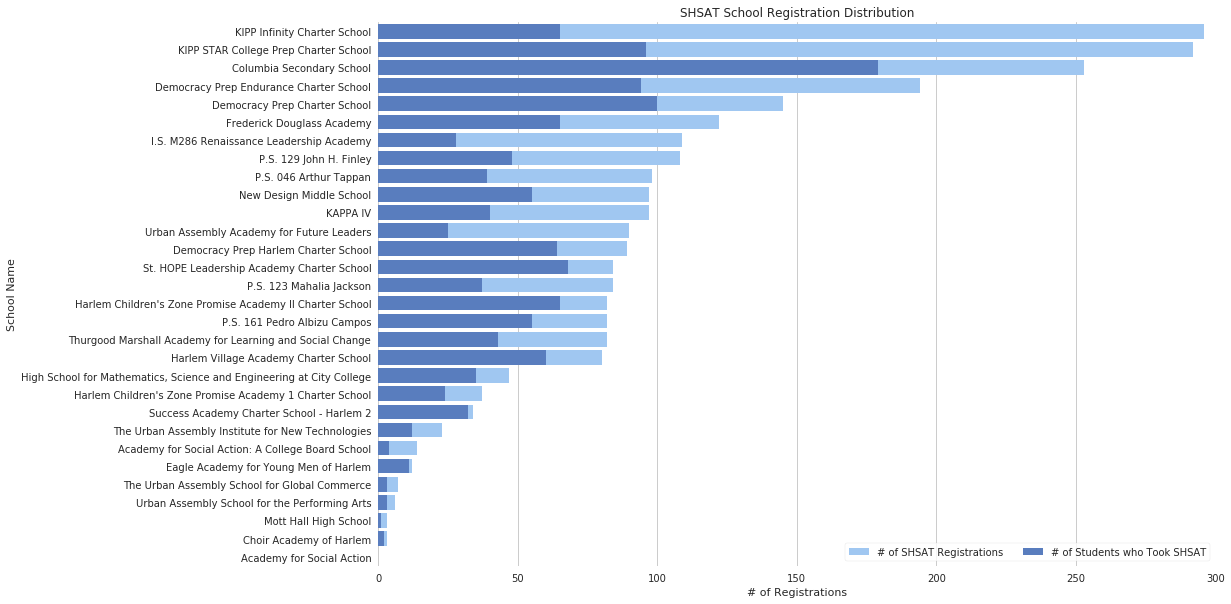

In [62]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

# Plot the total schools per city
sns.set_color_codes("pastel")
sns.barplot(x="Number of students who registered for the SHSAT", y='School name', data=shsat_sorted_df,
            label="# of SHSAT Registrations", color="b", ci=None)

# Plot the total community schools per city
sns.set_color_codes("muted")
sns.barplot(x="Number of students who took the SHSAT", y="School name", data=shsat_sorted_df,
            label="# of Students who Took SHSAT", color="b",ci=None)

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 300), ylabel="School Name", title='SHSAT School Registration Distribution',
       xlabel="# of Registrations")
sns.despine(left=True, bottom=True)
plt.show()

#### Based on the distribution of data, we have distinguished schools where the ratio of number of students appearing for SHSAT to number of students who registered for the same is low.

In [63]:
shsat_low_appearance_df = shsat_sorted_df[shsat_sorted_df['Took Percentage'] <= 0.4]
shsat_low_appearance_df.sort_values('Took Percentage')

,DBN,School name,Enrollment on 10/31,Number of students who registered for the SHSAT,Number of students who took the SHSAT,Year of SHST,Grade level,Took Percentage
22,84M336,KIPP Infinity Charter School,494,296,65,2016,8,0.219595
6,05M286,I.S. M286 Renaissance Leadership Academy,165,109,28,2015,8,0.256881
7,05M286,Urban Assembly Academy for Future Leaders,93,90,25,2016,8,0.277778
12,05M367,Academy for Social Action: A College Board School,254,14,4,2015,8,0.285714
29,84M726,KIPP STAR College Prep Charter School,292,292,96,2015,8,0.328767
9,05M304,Mott Hall High School,504,3,1,2014,8,0.333333
0,05M046,P.S. 046 Arthur Tappan,315,98,39,2013,8,0.397959


In [64]:
poor_schools_shsat_performance = list(np.unique(shsat_sorted_df['DBN']))
# poor_schools_shsat_performance = [i.strip().lower() for i in poor_schools_shsat_performance]

total_schools = list(set(df_schools['Location Code']))
# total_schools = [i.strip().lower() for i in total_schools]

print poor_schools_shsat_performance[:5]
print total_schools[:5]
intersection = list(set(poor_schools_shsat_performance).intersection(set(total_schools)))

print len(intersection)

['05M046', '05M123', '05M129', '05M148', '05M157']
['10X225', '14K318', '16K035', '28Q008', '10X342']
21


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4., 16.]),
 array([65. , 68.3, 71.6, 74.9, 78.2, 81.5, 84.8, 88.1, 91.4, 94.7, 98. ]),
 <a list of 10 Patch objects>)

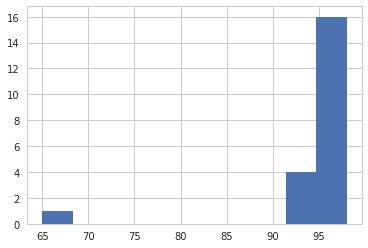

In [65]:
percent_black_hist = []
for school in intersection:
    percent_black_hist.append(list(df_schools[df_schools['Location Code'] == school]['Percent Black / Hispanic'])[0])
  
plt.hist(percent_black_hist)

#### As seen from the histogram above, the percentage of Black and Hispanic students is high where the percent of students taking the exam after registration is low.

In [66]:
df3 = pd.read_csv('../../../input/shsat_schoolwise_students_offers.csv')
merged_df = pd.merge(df_schools, df3, how='inner', left_on=['Location Code'], right_on=['School DBN'])

In [67]:
merged_df.columns.values

array(['School Name_x', 'SED Code', 'Location Code', 'District',
       'Latitude', 'Longitude', 'Address (Full)', 'City', 'Zip', 'Grades',
       'Grade Low', 'Grade High', 'Community School?',
       'Economic Need Index', 'School Income Estimate', 'Percent ELL',
       'Percent Asian', 'Percent Black', 'Percent Hispanic',
       'Percent Black / Hispanic', 'Percent White',
       'Student Attendance Rate',
       'Percent of Students Chronically Absent', 'Rigorous Instruction %',
       'Rigorous Instruction Rating', 'Collaborative Teachers %',
       'Collaborative Teachers Rating', 'Supportive Environment %',
       'Supportive Environment Rating', 'Effective School Leadership %',
       'Effective School Leadership Rating',
       'Strong Family-Community Ties %',
       'Strong Family-Community Ties Rating', 'Trust %', 'Trust Rating',
       'Student Achievement Rating', 'Average ELA Proficiency',
       'Average Math Proficiency', 'Grade 3 ELA - All Students Tested',
       'Gr

In [68]:
merged_df['SPI'].corr(merged_df['Number of students who received offer'])

-0.07999169829889007

Text(0.5,0,u'Longitude')

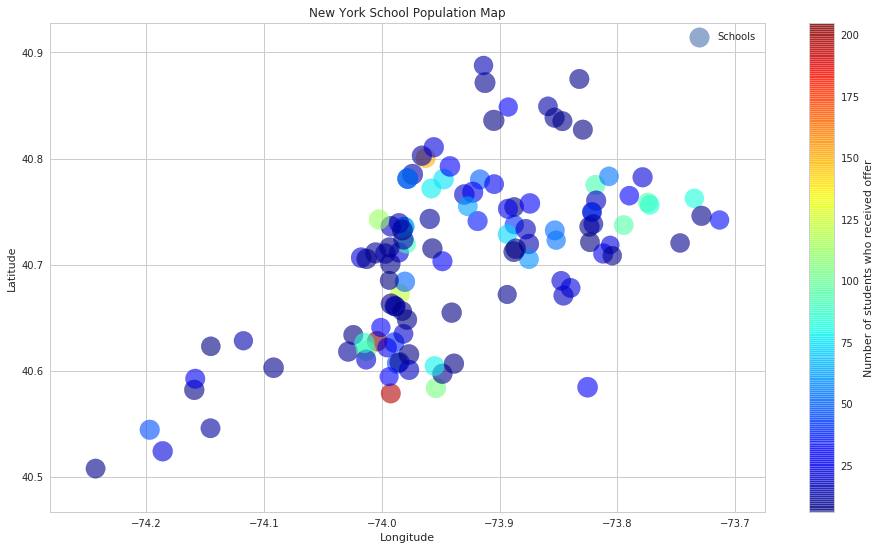

In [69]:
fig, ax = plt.subplots(figsize=(16,9))
ax = merged_df.plot(kind="scatter", x="Longitude", y="Latitude", 
                   s=merged_df['SPI']*1.5, c="Number of students who received offer", cmap=plt.get_cmap("jet"), 
                   label='Schools', title='New York School Population Map', 
                   colorbar=True, alpha=0.6, ax=ax)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

In [70]:
merged_df.shape

(554, 168)

In [71]:
merged_df['SPI'].describe()

count    554.000000
mean     256.345823
std       17.595525
min        0.000000
25%      246.870304
50%      256.782591
75%      266.289690
max      295.000000
Name: SPI, dtype: float64

In [72]:
df_schools['SPI'].describe()

count    620.000000
mean     256.888725
std       17.704105
min        0.000000
25%      246.870357
50%      257.189439
75%      267.242915
max      295.000000
Name: SPI, dtype: float64

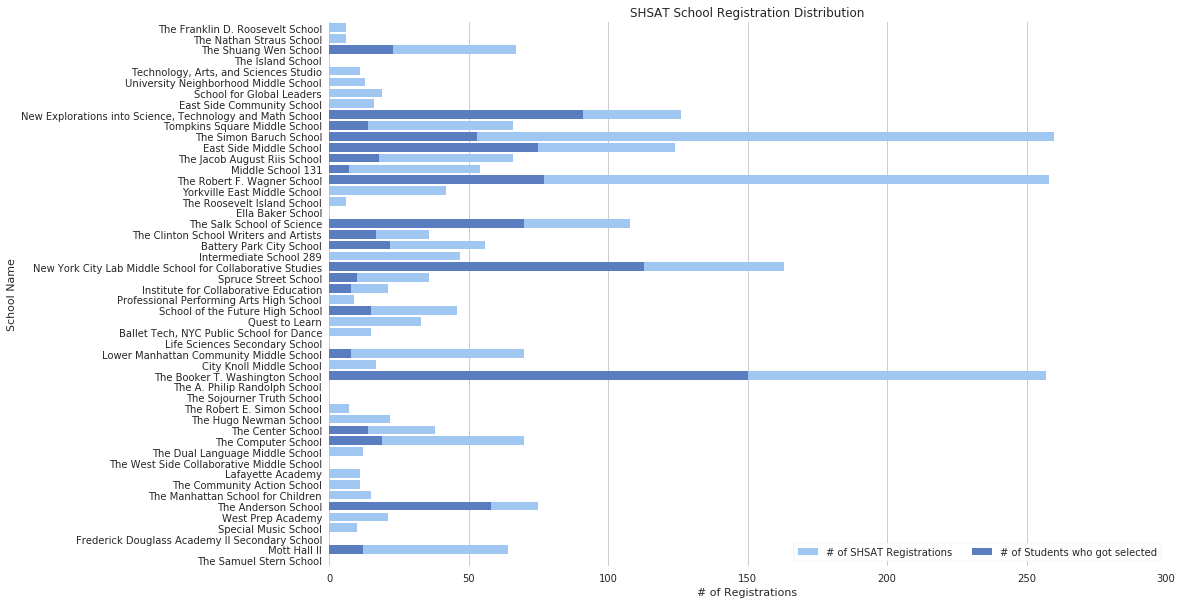

In [73]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 10))

# Plot the total schools per city
sns.set_color_codes("pastel")
sns.barplot(x="Number of students who took test", y='School Name_y', data=merged_df[:50],
            label="# of SHSAT Registrations", color="b", ci=None)

# Plot the total community schools per city
sns.set_color_codes("muted")
sns.barplot(x="Number of students who received offer", y="School Name_y", data=merged_df[:50],
            label="# of Students who got selected", color="b",ci=None)


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 300), ylabel="School Name", title='SHSAT School Registration Distribution',
       xlabel="# of Registrations")
sns.despine(left=True, bottom=True)
plt.show()

In [74]:
len(merged_df)

554

In [75]:
# mergred_df_non_null = merged_df.dropna(subset=['Number of students who took test'])
merged_df['Percentage of students receiving offer'] = merged_df['Number of students who received offer']/merged_df['Number of students who took test']

In [76]:
merged_df['Percentage of students receiving offer'].describe()

count    117.000000
mean       0.266447
std        0.175290
min        0.051095
25%        0.131068
50%        0.202128
75%        0.336283
max        0.816733
Name: Percentage of students receiving offer, dtype: float64

In [77]:
high_selection = merged_df[merged_df['Percentage of students receiving offer']>merged_df['Percentage of students receiving offer'].quantile(0.5)]
low_selection = merged_df[merged_df['Percentage of students receiving offer']<merged_df['Percentage of students receiving offer'].quantile(0.5)]

In [78]:
high_selection[['Average ELA Proficiency','Average Math Proficiency']].median()

Average ELA Proficiency     3.14
Average Math Proficiency    3.38
dtype: float64

In [79]:
low_selection[['Average ELA Proficiency','Average Math Proficiency']].median()

Average ELA Proficiency     2.715
Average Math Proficiency    2.880
dtype: float64

In [80]:
schools_null_students = merged_df[merged_df['Number of students who received offer'].isnull()]

In [81]:
len(schools_null_students)

437

In [82]:
schools_null_students[['Average ELA Proficiency','Average Math Proficiency']].mean()

Average ELA Proficiency     2.432197
Average Math Proficiency    2.486430
dtype: float64

In [83]:
schools_null_students['Percent Black / Hispanic'].describe()

count    437.000000
mean      86.851259
std       17.858730
min       11.000000
25%       86.000000
50%       95.000000
75%       97.000000
max      100.000000
Name: Percent Black / Hispanic, dtype: float64

In [84]:
high_selection['Percent Black / Hispanic'].describe()

count    58.000000
mean     28.362069
std      15.496121
min       7.000000
25%      15.000000
50%      27.500000
75%      35.750000
max      80.000000
Name: Percent Black / Hispanic, dtype: float64

In [85]:
low_selection['Percent Black / Hispanic'].describe()

count    58.000000
mean     49.534483
std      23.314189
min       7.000000
25%      29.000000
50%      55.000000
75%      65.500000
max      98.000000
Name: Percent Black / Hispanic, dtype: float64

In [86]:
print high_selection['School Income Estimate'].describe()
print low_selection['School Income Estimate'].describe()

count    1.900000e+01
mean     6.845846e+06
std      2.915822e+06
min      3.891961e+06
25%      5.254352e+06
50%      6.199444e+06
75%      7.373779e+06
max      1.439265e+07
Name: School Income Estimate, dtype: float64
count    1.300000e+01
mean     5.828566e+06
std      1.992906e+06
min      2.736508e+06
25%      4.836164e+06
50%      5.236111e+06
75%      6.428002e+06
max      1.117437e+07
Name: School Income Estimate, dtype: float64


In [87]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=4)
model.fit(schools_null_students[['Longitude', 'Latitude']].values)
model.cluster_centers_
color = 'blue'

In [88]:
school_map = folium.Map([model.cluster_centers_[:, 1].mean(), model.cluster_centers_[:, 0].mean()], 
                        zoom_start=11,
                        tiles='Stamen Terrain') 
for row in model.cluster_centers_:
    folium.Marker([row[1], row[0]], icon=folium.Icon(color='red')).add_to(school_map)
for index in schools_null_students.index:
    row = schools_null_students.loc[index]
#     if row['Economic Need Index'] > 0.8 and row['SPI'] < 243.55:
    popup_text = "Economic Need Index : " + str(round(row['Economic Need Index'], 3)) + ' , SPI : ' + str(round(row['SPI'], 3))
    folium.Marker([row['Latitude'], row['Longitude']], popup=popup_text, icon=folium.Icon(color='blue')).add_to(school_map)

school_map

In [89]:
def find_schools_with_black_high_4s_low(df, grade = 5, black_per_threshold = 90, all_students_threshold = 10):
    math_black_students = "Grade {} Math 4s - Black or African American".format(grade)
    math_hispanic_students = "Grade {} Math 4s - Hispanic or Latino".format(grade)
    math_all_students = "Grade {} Math 4s - All Students".format(grade)
    
    print "Number of schools in df:" + str(len(df))
    df_schools = df.copy()
    
    df_schools['4s ratio black / hispanic'] = (df_schools[math_black_students] + df_schools[math_hispanic_students])/ df_schools[math_all_students]
    df_schools_black_4s = df_schools[df_schools['Percent Black / Hispanic'] > black_per_threshold]
    print "Number of schools black high:" + str(len(df_schools_black_4s))
    df_schools_black_4s = df_schools[df_schools[math_all_students] > all_students_threshold]
    print "Number of schools high 4s:" + str(len(df_schools_black_4s))
    df_schools_black_4s_low = df_schools_black_4s[df_schools_black_4s['4s ratio black / hispanic'] > 0.75]
    print "Number of schools high black ratio:" + str(len(df_schools_black_4s_low))
    
    num_schools = len(df_schools_black_4s_low)                      
   
    return df_schools_black_4s_low

In [90]:
schools_with_black_high_4s_low = []

for grade in xrange(7,9):
    print "Grade " + str(grade)
    df_schools_with_black_high_4s_low = find_schools_with_black_high_4s_low(schools_null_students, grade=grade)
    schools_with_black_high_4s_low.extend(np.unique(df_schools_with_black_high_4s_low['School DBN']))
print len(schools_with_black_high_4s_low)
schools_with_black_high_4s_low = list(set(schools_with_black_high_4s_low))

Grade 7
Number of schools in df:437
Number of schools black high:303
Number of schools high 4s:79
Number of schools high black ratio:32
Grade 8
Number of schools in df:437
Number of schools black high:303
Number of schools high 4s:55
Number of schools high black ratio:28
60


In [91]:
len(schools_with_black_high_4s_low)

48

In [92]:
# print set(schools_with_black_high_4s_low)
# print set(schools_null_students['School DBN'])
print set(schools_with_black_high_4s_low).intersection(set(schools_null_students['School DBN']))
print set(schools_with_black_high_4s_low).intersection(set(high_selection['School DBN']))
print set(schools_with_black_high_4s_low).intersection(set(low_selection['School DBN']))

set(['84M384', '09X004', '32K347', '84R073', '84M385', '09X454', '84K712', '12X214', '10X015', '12X211', '84M336', '84M335', '06M223', '84X704', '84K517', '84M068', '84K608', '32K554', '08X337', '10X447', '84K593', '29Q208', '17K138', '11X180', '07X223', '84M350', '32K383', '17K002', '84K357', '84K355', '84K538', '84M341', '23K392', '17K354', '18K211', '84M430', '17K061', '17K189', '84K508', '19K452', '84X496', '84K652', '08X302', '84K775', '04M171', '10X244', '18K285', '84K777'])
set([])
set([])


In [93]:
df_filtered_schools = df_schools[df_schools['Location Code'].isin(schools_with_black_high_4s_low)]
df_filtered_schools[['School Name', 'City', 'Economic Need Index', 'SPI']]

,School Name,City,Economic Need Index,SPI
119,P.S. 171 PATRICK HENRY,NEW YORK,0.751,268.069538
176,THE MOTT HALL SCHOOL,NEW YORK,0.724,257.089281
210,M.S. 223 THE LABORATORY SCHOOL OF FINANCE AND ...,BRONX,0.866,242.806002
244,M.S. 302 LUISA DESSUS CRUZ,BRONX,0.906,257.299581
248,THE SCHOOL FOR INQUIRY AND SOCIAL JUSTICE,BRONX,0.781,271.142993
257,P.S./M.S. 004 CROTONA PARK WEST,BRONX,0.903,250.142787
305,SCIENCE AND TECHNOLOGY ACADEMY: A MOTT HALL SC...,BRONX,0.860,282.857750
314,P.S. X015 INSTITUTE FOR ENVIRONMENTAL LEARNING,BRONX,0.852,255.190025
343,THE NEW SCHOOL FOR LEADERSHIP AND JOURNALISM,BRONX,0.850,266.705841
366,CRESTON ACADEMY,BRONX,0.898,266.947612


In [94]:
set(df_schools_clustering['Location Code']).intersection(set(schools_with_black_high_4s_low))

{'07X223'}

In [177]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
import folium
import sklearn
import seaborn as sns
from IPython.core.display import display, HTML
import ipywidgets as widgets
from IPython.display import clear_output
import itertools

In [171]:
df_schools_minor = df_schools_raw[df_schools_raw['Percent Black / Hispanic'].astype(int)>70]
print(df_schools_minor.shape)

(829, 161)


In [172]:
def grade_minority_percent_4s (df, grade, subject, thres_total_4s, thres_minority):
    out_field = ('Grade %d %s Minority 4s')%(grade, subject)
    num1 = ('Grade %d %s 4s - Black or African American')%(grade, subject)
    num2 = ('Grade %d %s 4s - Hispanic or Latino')%(grade, subject)
    den = ('Grade %d %s 4s - All Students')%(grade, subject)

    df = df[df[den].astype(int)>thres_total_4s]
    df[out_field] = (df[num1] + df[num2])/(df[den])
    grade_minority_df = df[df[out_field]>thres_minority]

    df_html = grade_minority_df[['Location Code','School Name', out_field, num1, num2, den]].head().to_html()
    display(HTML(df_html))

    return df

In [173]:
def compute_4s_minority_states():
    grade = int(toggle.value.split(" ")[1])
    subjects = ['ELA', 'Math']

    plt.figure(figsize=[19,10])
    df_all_schools = pd.DataFrame(columns=df_schools_minor.columns)
    column_list = []

    for subject in subjects:
        df_all_schools = grade_minority_percent_4s(df_schools_minor, grade, subject, thres_total_4s.value, thres_minority.value)
#         out_field = ('Grade %d %s Minority 4s')%(grade, subject)
#         num1 = ('Grade %d %s 4s - Black or African American')%(grade, subject)
#         num2 = ('Grade %d %s 4s - Hispanic or Latino')%(grade, subject)
#         den = ('Grade %d %s 4s - All Students')%(grade, subject)

In [174]:
style = {'description_width': 'initial'}

def on_value_change(change):
    clear_output()
    display(thres_total_4s)
    display(thres_minority)
    display(toggle)
    compute_4s_minority_states()
    
thres_total_4s = widgets.IntSlider(
    value = 5,
    min=0,
    max=20,
    step=1,
    description='Total Students with 4s',
    style=style,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
thres_total_4s.observe(on_value_change, names='value')
# display(thres_total_4s)

thres_minority = widgets.FloatSlider(
    value=0.7,
    min=0,
    max=1.0,
    step=0.05,
    description='Ratio of minority students',
    style=style,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)
thres_minority.observe(on_value_change, names='value')
# display(thres_minority)

In [175]:
toggle = widgets.ToggleButtons(
    options=['Grade 5', 'Grade 6', 'Grade 7', 'Grade 8'],
    value='Grade 8',
    description='Grades:',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Info. about Grade 5', 'Info. about Grade 6', 'Info. about Grade 7', 'Info. about Grade 8'],
#     icons=['check'] * 3
)

In [178]:
display(toggle)
display(thres_total_4s)
display(thres_minority)

compute_4s_minority_states()

def on_click(change):
    clear_output()
    
    display(thres_total_4s)
    display(thres_minority)
    display(toggle)
    
    compute_4s_minority_states()
    
toggle.observe(on_click, 'value')

ToggleButtons(button_style=u'info', description=u'Grades:', index=3, options=('Grade 5', 'Grade 6', 'Grade 7', 'Grade 8'), tooltips=[u'Info. about Grade 5', u'Info. about Grade 6', u'Info. about Grade 7', u'Info. about Grade 8'], value='Grade 8')

IntSlider(value=5, continuous_update=False, description=u'Total Students with 4s', max=20, style=SliderStyle(description_width=u'initial'))

FloatSlider(value=0.7, continuous_update=False, description=u'Ratio of minority students', max=1.0, step=0.05, style=SliderStyle(description_width=u'initial'))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Location Code,School Name,Grade 8 ELA Minority 4s,Grade 8 ELA 4s - Black or African American,Grade 8 ELA 4s - Hispanic or Latino,Grade 8 ELA 4s - All Students
111,04M057,JAMES WELDON JOHNSON,0.777778,1,6,9
116,04M108,P.S. 108 ASSEMBLYMAN ANGELO DEL TORO EDUCATION...,0.750000,2,4,8
119,04M171,P.S. 171 PATRICK HENRY,0.850000,4,13,20
160,06M052,J.H.S. 052 INWOOD,0.818182,0,9,11
165,06M143,J.H.S. 143 ELEANOR ROOSEVELT,1.000000,0,7,7


,Location Code,School Name,Grade 8 Math Minority 4s,Grade 8 Math 4s - Black or African American,Grade 8 Math 4s - Hispanic or Latino,Grade 8 Math 4s - All Students
119,04M171,P.S. 171 PATRICK HENRY,0.862069,2,23,29
157,06M018,P.S. 018 PARK TERRACE,1.000000,0,8,8
177,06M278,PAULA HEDBAVNY SCHOOL,1.000000,0,7,7
178,06M293,CITY COLLEGE ACADEMY OF THE ARTS,0.857143,0,6,7
210,07X223,M.S. 223 THE LABORATORY SCHOOL OF FINANCE AND ...,0.800000,0,12,15


In [136]:
df_passnyc_centers = pd.read_csv('../../../input/PASSNYC Resource Centres.csv')
df_passnyc_center_types = pd.read_csv('../../../input/ResourceCenters_tagged.csv')

In [137]:
df_passnyc_centers.columns

Index([u'Address', u'Borough', u'Category', u'Description', u'Lat', u'Long',
       u'Name', u'Website'],
      dtype='object')

In [138]:
df_passnyc_center_types.columns

Index([u'No.', u'Name', u'Category', u'Sub-category Short Description',
       u'Sub-category', u'Location Specific', u'Test Prep',
       u'After School Program', u'Crime', u'Economic Help'],
      dtype='object')

In [154]:
print list(df_passnyc_center_types['Name'])
print list(set(df_passnyc_centers['Name']))

['Greenhouse Arts Center ', 'JCC Harlem', 'VOYCE', 'NHEMA', 'Harlem Renaissance Education Pipeline (HREP)', 'Mindful Harlem', 'Stuyvesant Student Union', 'Harlem Grown', 'District 5 Community Education Council', 'Make A Play', 'FC Harlem', 'Exam Schools Partnership Initative (ESPI)', 'RQM Tutorial', 'School Plus', 'Citizen Schools', 'Breakthrough New York', 'Admissions Squad', 'Manhattan Prep', 'Khanu0027s Tutorial', 'Bell Curves', 'Apex for Youth', 'Kweller Prep', 'CASPrep', 'Princeton Review', 'Kaplan', 'Bridge to Enter Advanced Mathematics ', 'The Parris Foundation', 'STEM Kids NYC']
['Admissions Squad', 'FC Harlem', 'Bell Curves', 'Khanu0027s Tutorial', 'Kaplan', 'Greenhouse Arts Center ', 'Citizen Schools', 'RQM Tutorial', 'CASPrep', 'The Parris Foundation', 'VOYCE', 'STEM Kids NYC', 'Princeton Review', 'Bridge to Enter Advanced Mathematics ', 'School Plus', 'Harlem Grown', 'Breakthrough New York', 'JCC Harlem', 'Make A Play', 'Apex for Youth', 'Exam Schools Partnership Initative 

In [148]:
center_names = list(df_passnyc_centers['Name'])
center_type = list(df_passnyc_center_types['Name'])

for name in center_names:
    if not name in center_type:
        print name

In [156]:
merged_passnyc_df = pd.merge(df_passnyc_centers, df_passnyc_center_types, how='inner', left_on=['Name'], right_on=['Name'])

In [157]:
merged_passnyc_df.head()

,Address,Borough,Category_x,Description,Lat,Long,Name,Website,No.,Category_y,Sub-category Short Description,Sub-category,Location Specific,Test Prep,After School Program,Crime,Economic Help
0,Harlem,Manhattan,Test Prep u0026 Tutoring,The Exam Schools Partnership Initiative (ESPI)...,40.744722,-73.993641,Exam Schools Partnership Initative (ESPI),espi.nyc,12,Test Prep u0026 Tutoring,Provides Education support to talented kids fr...,Economically low,NaN,1,0,0,1
1,"29-10 36th Ave, Astoria, NY 11106",Queens,Test Prep u0026 Tutoring,"RQM Tutorial provides low cost, high quality t...",40.757083,-73.931165,RQM Tutorial,rqmtutorial.com,13,Test Prep u0026 Tutoring,Student tutoring|Preparation of Standarized En...,Economically low,Queens,1,0,0,1
2,"89-16 175 Street, S Jamaica 11432",Queens,Test Prep u0026 Tutoring,"RQM Tutorial provides low cost, high quality t...",40.710124,-73.786863,RQM Tutorial,rqmtutorial.com,13,Test Prep u0026 Tutoring,Student tutoring|Preparation of Standarized En...,Economically low,Queens,1,0,0,1
3,"2 Russell Pl, Flushing, NY 11375",Queens,Test Prep u0026 Tutoring,School Plus offers a Weekend Enrichment Progra...,40.715537,-73.843379,School Plus,school-plus.com,14,Test Prep u0026 Tutoring,Weekend En-richment Program|Preparation of Sta...,NaN,NaN,1,0,0,0
4,"50 Avenue X, Brooklyn, NY, 11223",Brooklyn,Test Prep u0026 Tutoring,School Plus offers a Weekend Enrichment Progra...,40.587672,-73.981469,School Plus,school-plus.com,14,Test Prep u0026 Tutoring,Weekend En-richment Program|Preparation of Sta...,NaN,NaN,1,0,0,0


In [167]:
crime_relief_centers = merged_passnyc_df[merged_passnyc_df['Crime']==1]
test_prep_centers = merged_passnyc_df[merged_passnyc_df['Test Prep']==1]
after_school_centers = merged_passnyc_df[merged_passnyc_df['After School Program']==1]
economic_help_centers = merged_passnyc_df[merged_passnyc_df['Economic Help']==1]

In [168]:
print len(crime_relief_centers)
print len(test_prep_centers)
print len(after_school_centers)
print len(economic_help_centers)

2
60
8
26


In [179]:
len(risky_schools_df)

54

In [166]:
# CRIME

school_map = folium.Map([model.cluster_centers_[:, 1].mean(), model.cluster_centers_[:, 0].mean()], 
                        zoom_start=11,
                        tiles='Stamen Terrain') 
# for row in model.cluster_centers_:
#     folium.Marker([row[1], row[0]], icon=folium.Icon(color='red')).add_to(school_map)
for index in risky_schools_df.index:
    row = risky_schools_df.loc[index]
#     if row['Economic Need Index'] > 0.8 and row['SPI'] < 243.55:
#     popup_text = "Economic Need Index : " + str(round(row['Economic Need Index'], 3)) + ' , SPI : ' + str(round(row['SPI'], 3))
    folium.Marker([row['Latitude'], row['Longitude']], popup=popup_text, icon=folium.Icon(color='blue')).add_to(school_map)

for index in crime_relief_centers.index:
    row = crime_relief_centers.loc[index]
#     if row['Economic Need Index'] > 0.8 and row['SPI'] < 243.55:
#     popup_text = "Economic Need Index : " + str(round(row['Economic Need Index'], 3)) + ' , SPI : ' + str(round(row['SPI'], 3))
    folium.Marker([row['Lat'], row['Long']], popup=popup_text, icon=folium.Icon(color='red')).add_to(school_map)
    
school_map

In [170]:
# ECONOMIC HELP CENTERS

school_map = folium.Map([model.cluster_centers_[:, 1].mean(), model.cluster_centers_[:, 0].mean()], 
                        zoom_start=11,
                        tiles='Stamen Terrain') 
# for row in model.cluster_centers_:
#     folium.Marker([row[1], row[0]], icon=folium.Icon(color='red')).add_to(school_map)
for index in df_schools_high_eni.index:
    row = df_schools_high_eni.loc[index]
#     if row['Economic Need Index'] > 0.8 and row['SPI'] < 243.55:
#     popup_text = "Economic Need Index : " + str(round(row['Economic Need Index'], 3)) + ' , SPI : ' + str(round(row['SPI'], 3))
    folium.Marker([row['Latitude'], row['Longitude']], popup=popup_text, icon=folium.Icon(color='blue')).add_to(school_map)

for index in economic_help_centers.index:
    row = economic_help_centers.loc[index]
#     if row['Economic Need Index'] > 0.8 and row['SPI'] < 243.55:
#     popup_text = "Economic Need Index : " + str(round(row['Economic Need Index'], 3)) + ' , SPI : ' + str(round(row['SPI'], 3))
    folium.Marker([row['Lat'], row['Long']], popup=popup_text, icon=folium.Icon(color='red')).add_to(school_map)
    
school_map

In [ ]:
# TEST PREP CENTERS

school_map = folium.Map([model.cluster_centers_[:, 1].mean(), model.cluster_centers_[:, 0].mean()], 
                        zoom_start=11,
                        tiles='Stamen Terrain') 
# for row in model.cluster_centers_:
#     folium.Marker([row[1], row[0]], icon=folium.Icon(color='red')).add_to(school_map)
for index in poor_schools_shsat_performance.index:
    row = risky_schools_df.loc[index]
#     if row['Economic Need Index'] > 0.8 and row['SPI'] < 243.55:
#     popup_text = "Economic Need Index : " + str(round(row['Economic Need Index'], 3)) + ' , SPI : ' + str(round(row['SPI'], 3))
    folium.Marker([row['Latitude'], row['Longitude']], popup=popup_text, icon=folium.Icon(color='blue')).add_to(school_map)

for index in test_prep_centers.index:
    row = test_prep_centers.loc[index]
#     if row['Economic Need Index'] > 0.8 and row['SPI'] < 243.55:
#     popup_text = "Economic Need Index : " + str(round(row['Economic Need Index'], 3)) + ' , SPI : ' + str(round(row['SPI'], 3))
    folium.Marker([row['Lat'], row['Long']], popup=popup_text, icon=folium.Icon(color='red')).add_to(school_map)
    
school_map

In [ ]:
# AFTER SCHOOL CENTERS

school_map = folium.Map([model.cluster_centers_[:, 1].mean(), model.cluster_centers_[:, 0].mean()], 
                        zoom_start=11,
                        tiles='Stamen Terrain') 
# for row in model.cluster_centers_:
#     folium.Marker([row[1], row[0]], icon=folium.Icon(color='red')).add_to(school_map)
for index in risky_schools_df.index:
    row = risky_schools_df.loc[index]
#     if row['Economic Need Index'] > 0.8 and row['SPI'] < 243.55:
#     popup_text = "Economic Need Index : " + str(round(row['Economic Need Index'], 3)) + ' , SPI : ' + str(round(row['SPI'], 3))
    folium.Marker([row['Latitude'], row['Longitude']], popup=popup_text, icon=folium.Icon(color='blue')).add_to(school_map)

for index in after_school_centers.index:
    row = after_school_centers.loc[index]
#     if row['Economic Need Index'] > 0.8 and row['SPI'] < 243.55:
#     popup_text = "Economic Need Index : " + str(round(row['Economic Need Index'], 3)) + ' , SPI : ' + str(round(row['SPI'], 3))
    folium.Marker([row['Lat'], row['Long']], popup=popup_text, icon=folium.Icon(color='red')).add_to(school_map)
    
school_map